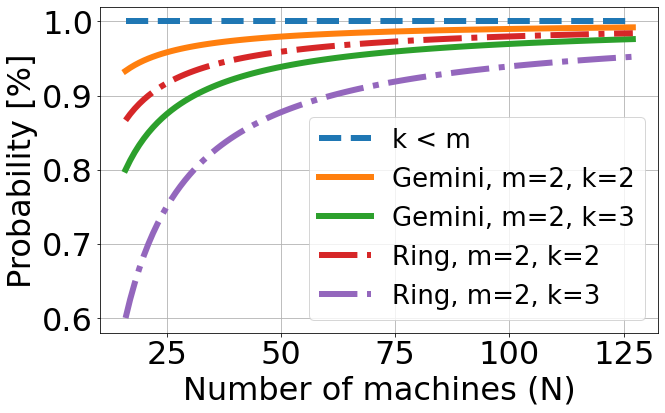

In [9]:
# Figure 9, the probability

import pandas as pd
import operator as op
import matplotlib.pyplot as plt
from functools import reduce


def comb(n, r):
    if n == r:
        return 1
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

max_power = 7
nums = [i for i in range(2**4, 2**max_power)]


def get_recovery_rate_ring(nums, m, k):
    rates = []
    if k < m:
        return [1 for _ in nums]
    
    for num in nums:
        rate = num / comb(num, k) * comb(num-m, k-m)
        rates.append(1 - rate)
    return rates


def get_recovery_rate_group(nums, m, k):
    rates = []
    if k < m:
        return [1 for _ in nums]
    
    for num in nums:
        rate = num / m / comb(num, k) * comb(num-m, k-m)
        rates.append(1 - rate)
    return rates

recovery_rate_group_2_1 = get_recovery_rate_ring(nums, 2, 1)
recovery_rate_ring_2_2 = get_recovery_rate_ring(nums, 2, 2)
recovery_rate_ring_2_3 = get_recovery_rate_ring(nums, 2, 3)
recovery_rate_group_2_2 = get_recovery_rate_group(nums, 2, 2)
recovery_rate_group_2_3 = get_recovery_rate_group(nums, 2, 3)


df = pd.DataFrame({
    'k < m': recovery_rate_group_2_1,
    'Gemini, m=2, k=2': recovery_rate_group_2_2,
    'Gemini, m=2, k=3': recovery_rate_group_2_3,
    'Ring, m=2, k=2': recovery_rate_ring_2_2,
    'Ring, m=2, k=3': recovery_rate_ring_2_3,
}, index=nums)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=[ '--', '-', '-', '-.', '-.', '--',])
lines.set_xlabel("Number of machines (N)", fontdict={'fontsize':32})
lines.set_ylabel("Probability [%]", fontdict={'fontsize':32})

# plt.ylim(75, 101)
plt.legend(loc=0, ncol=1, prop={'size': 26})
plt.savefig("Figure_9.png", bbox_inches='tight')

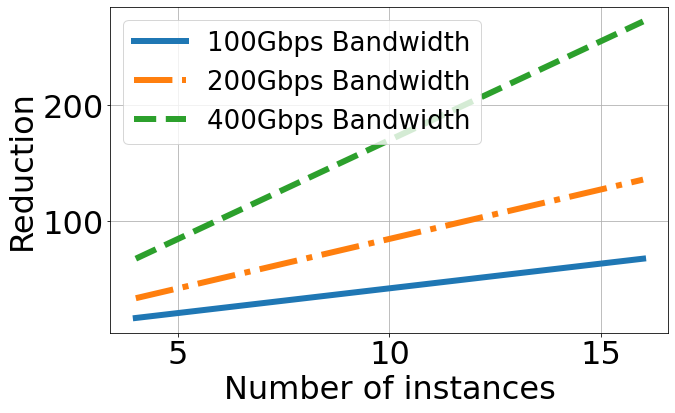

In [10]:
# Figure 11, checkpoint time reduction

import pandas as pd
import numpy
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

nums = numpy.array([4, 8, 12, 16])

def speedup_num(nums, remote_bandwidth, instance_bandwidth, m=2):
    checkpoint = []
    retrieval = []

    for num in nums:
        csp = instance_bandwidth * num / (m-1) / remote_bandwidth
        checkpoint.append(csp)

        rsp = instance_bandwidth * num / remote_bandwidth
        retrieval.append(rsp)
    return checkpoint, retrieval

remote_bandwidth = 20
network_utilization = 0.85
instance_bandwidth = 100 * network_utilization
checkpoint_100, retrieval_100 = speedup_num(nums, remote_bandwidth, instance_bandwidth, 2)

instance_bandwidth = 200 * network_utilization
checkpoint_200, retrieval_200 = speedup_num(nums, remote_bandwidth, instance_bandwidth, 2)

instance_bandwidth = 400 * network_utilization
checkpoint_400, retrieval_400 = speedup_num(nums, remote_bandwidth, instance_bandwidth, 2)


df = pd.DataFrame({
    '100Gbps Bandwidth': checkpoint_100,
    '200Gbps Bandwidth': checkpoint_200,
    '400Gbps Bandwidth': checkpoint_400,
   }, index=nums)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['-','-.','--',':'])

# plt.ylim(1, 12)
# plt.xlim(0.9, 100)
lines.set_xlabel("Number of instances", fontdict={'fontsize':32})
lines.set_ylabel("Reduction", fontdict={'fontsize':32})
plt.legend(loc=0, ncol=1, frameon=True)
plt.savefig("Figure_11.png", bbox_inches='tight')

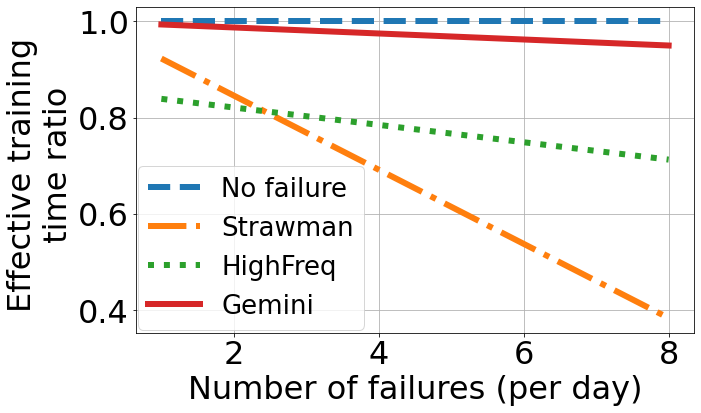

In [12]:
# Figure 14a, effective training time ratio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

failures = np.array([i for i in range(1, 9)])

# 100B, 16 p4d instances
total_time = 60 * 24 # min

def gemini_performance(failures):
    overhead = 9 # min
    perfs = []
    for failure in failures:
        perfs.append(1 - overhead * failure / total_time)
    return perfs


def deepspeed_performance(failures):
    overhead = 1.5 * 60 + 12 + 9
    perfs = []
    for failure in failures:
        perfs.append(1 - overhead * failure / total_time)
    return perfs


def highfreq_performance(failures):
    overhead = 26
    save_time = 80 # sec
    ckpt_time = 480  # sec
    perfs = []
    for failure in failures:
        perfs.append(ckpt_time/(save_time+ckpt_time) - overhead * failure / total_time)
    return perfs

deepspeed = deepspeed_performance(failures)
highfreq = highfreq_performance(failures)
gemini = gemini_performance(failures)
no_failure = np.array([1 for i in range(1, 9)])

df = pd.DataFrame({
    'No failure': no_failure,
    'Strawman': deepspeed,
    'HighFreq': highfreq,
    'Gemini': gemini,
   }, index=failures)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['--','-.',':','-'])

# plt.xlim(0.9, 100)
lines.set_xlabel("Number of failures (per day)", fontdict={'fontsize':32})
lines.set_ylabel("Effective training \n time ratio", fontdict={'fontsize':32})
plt.legend(loc=3, ncol=1, frameon=True, bbox_to_anchor=(-0.02, -0.03))
plt.savefig("Figure_14a.png", bbox_inches='tight')

In [ ]:
# Figure 14a, effective training time ratio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

total_time = 60 * 24 # min

machines = [i * 100 for i in range(2, 11)]

# 1T model
failure_rate = 0.015
# 1.5% per day from training of OPT-175B, Opt: Open pre-trained transformer language models, https://arxiv.org/abs/2205.01068

def gemini_performance(machines):
    overhead = 9 # min
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(1 - overhead * failures / total_time)
    return perfs


def deepspeed_performance(machines):
    overhead = 1.5 * 60 + 12 + 9
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(max(0, 1 - overhead * failures / total_time))
    return perfs


def highfreq_performance(machines):
    overhead = 26
    save_time = 80 # sec
    ckpt_time = 480  # sec
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(ckpt_time/(save_time+ckpt_time) - overhead * failures / total_time)
    return perfs


deepspeed = deepspeed_performance(machines)
highfreq = highfreq_performance(machines)
gemini = gemini_performance(machines)
no_failure = np.array([1 for i in machines])

df = pd.DataFrame({
    'No failure': no_failure,
    'Strawman': deepspeed,
    'HighFreq': highfreq,
    'Gemini': gemini,
   }, index=machines)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['--','-.',':','-'])

# plt.xlim(0.9, 100)
lines.set_xlabel("Number of instances", fontdict={'fontsize':32})
lines.set_ylabel("Effective training \n time ratio", fontdict={'fontsize':32})
plt.legend(loc=3, ncol=1, frameon=True, bbox_to_anchor=(-0.02, -0.03))
plt.savefig("simulation_model_size.png", bbox_inches='tight')